9.3 现代 cnn 架构.ipynb

一个模型的架构包含了创建这个模型所有因素

- 使用那些 layer?
- 如何配置所有 layer?
- 最后如何组合 layer?

这些选择定义了模型的假设空间.

假设空间相当于是模型的权重作为参数,模型梯度下降所有可能的搜索空间.

与特征工程一样,好的假设空间包含了我们对问题和解决方案的先验知识.例如,模型使用了卷积层,意味着你知道我们需要从输入图像寻找的模式具有平移不变性.

模型架构选择往往决定了能不能成功解决问题.不恰当的模型会卡死在次优指标,无论多少的训练数据都无法拯救.好的模型往往能有效利用数据,减少对数据的需求,更容易收敛到最优点.

如同特征工程和数据整理,模型架构选择也是为了梯度下降更加高效,尝试对梯度下降写入下面的印象: 梯度下降过程是个非常愚蠢的过程,尽一切可能去帮助它.

模型架构的选择更像是艺术而不是科学,有经验的工程师往往可以更有效率构建出高性能模型,而初学者连构建可训练模型都会非常吃力.虽然没有一个绝对的标准,但是还有工程上的最佳实践,可以供新手参考.

下面我们会回顾一些 cnn 架构的最佳实践,特别是残差连接(residual connections) 批量规范化(batch normalization) 可分离卷积(separable convolutions),当真正掌握这些架构时,才能高效的构建模型.我们会在猫狗的的分类上再次应用这些架构.


ps: ​[深度学习-关于图像分类的经典10篇文章](https://zhuanlan.zhihu.com/p/375444596) 对图像分类感兴趣可以看看这篇文章.


## MHR

如果有一个构造复杂系统的通用方法,那么一定是 MRH.MHR 代表了模块化 层次化 复用,几乎任何能看到架构这个词的地方都有 MRH.

如果你是一名软件工程师,那么 MRH 应该已经非常熟悉了.软件开发中会涉及大量模块/复用/层次化的内容.

说会深度学习本身,深度学习本身是利用梯度下降应用在了连续优化

- 我们使用了经典额优化技术 -> 在连续函数空间上的梯度下降.
- 将搜索空间结构归结为一个 layer
- 最终将 layer 组合成一个模型.
- 以上过程中我们可能复用任何东西

深度学习模型中,不仅有 layer 级别的复用,流行的架构中还包括模块级别的复用.一个例子就是上一节我们使用的 VGG16 模型.

大多数的 cmm 架构都有金字塔式的结构,上一章我们的模型中随着深度增加,cnn 输出特征图的深度也在不断增加.如下图的 VGG16 也是这样的架构.

![vgg16_pyramid](vgg16_pyramid.png)


深度越深,学习到的模式越有可能复用.一般而言,参数量相同情况下,深度更深的表现更好.但是深度更深带来了另一个问题 -> 梯度消失.这引出了我们的第一个基本架构--剩余连接.


### 消融实验

深度学习的架构往往是演化出来的,而不是设计出来的.不断反复尝试迭代最终得到成品,类似生物系统,有可能删除/替换一些模块而不会损失性能.

深度学习研究人员面临的问题更加复杂一些.如果可以使系统比必要更加复杂,会提高论坛通过同行评审的几率.很多深度学习的论文会针对同行评审优化,损害了解释的清晰和结果的可靠性.例如深度学习论文中的数学,很少被用来解释形式化概率和推理非显而易见的结果,反而被用来包装论文,像是推销员的昂贵西装.

研究的目的并不只是为了发表,而是为了可靠的知识.显而易见的,了解你系统中的因果关系,是产生知识的可靠途径.有一种非常省力的研究因果关系的方法--消融研究/消融实验(ablation studies)

消融实验: 类似控制变量,不断尝试去掉系统的不同部分,将系统简单化,查看其对性能的影响.确定那些部分对系统性能产生影响.

如果你要成为一名深度学习的研究人员,要不断尝试降低模型的复杂度--尝试进行消融实验.不断反问自己: 是否有更简单的解释?增加这个模块是否真的比较?


## 残差连接

残差连接对应的是解决梯度消失问题.

将深度学习看作是一连串的函数调用.

y = f4(f3(f2(f1(x))))

- 最终的输出是 f4 函数,我们要根据 f4 输出的误差记录调整整个链条所有函数的参数.计算反向传播就是这个过程.
- 整个链条上,每经过一个函数都会引入一定的噪声,随着函数链越来越长,总会出现梯度信息消失在了噪声中 -> 梯度消失问题.

既然梯度信息是在链上直线传播,一层一层的被削弱(让我想起了自动控制理论),那么改变这样的线性连接,使得无损的信息可以跨层传播呢?

残差连接就是这样的,将上一层或者模块的输入叠加回输出.使得无损的信息可以跨层传播.

![residual_connection](residual_connection.png)


In [6]:
# x = ...
# residual = x
# x = block(x)
# x = add([x, residual])

简单情况下,残差连接如上所示.

输入叠加回输出意味着两者具有相同的形状,但是上一章提到的 cnn 层和最大池化层会改变输出的形状,这样的简单情况不再成立.


In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  #填充
residual = layers.Conv2D(64, 1)(residual)  # 不带激活函数 对输入进行处理 匹配输出
x = layers.add([x, residual])

cnn 层改变了输出形状

- `padding="same"` 防止宽高改变
- 不带激活的 Conv2D 处理深度轴的改变


In [9]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  #填充
x = layers.MaxPooling2D(2, padding="same")(x)  #最大池化 下采样 x0.5
residual = layers.Conv2D(64, 1,
                         strides=2)(residual)  # 不带激活函数 步长2 下采样 x0.5 处理输入 匹配输出
x = layers.add([x, residual])

cnn 层+最大池化 改变了输出形状

- `padding="same"` 防止宽高改变
- 不带激活的 Conv2D 处理深度轴的改变.步长2 下采样对应最大池化下采样.


In [10]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)  #数据转换


def residual_block(x, filters, pooling=False):  #模块
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:  #带最大池化
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x


x = residual_block(x, filters=32, pooling=True)  #使用了3个模块
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)  #全局平均值池化
outputs = layers.Dense(1, activation="sigmoid")(x)  #输出层
model = keras.Model(inputs=inputs, outputs=outputs)

这是一个可能的例子,复用了3次模块


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_17[0][0]                  
____________________________________________________________________________________________

模型结构,有点晕.

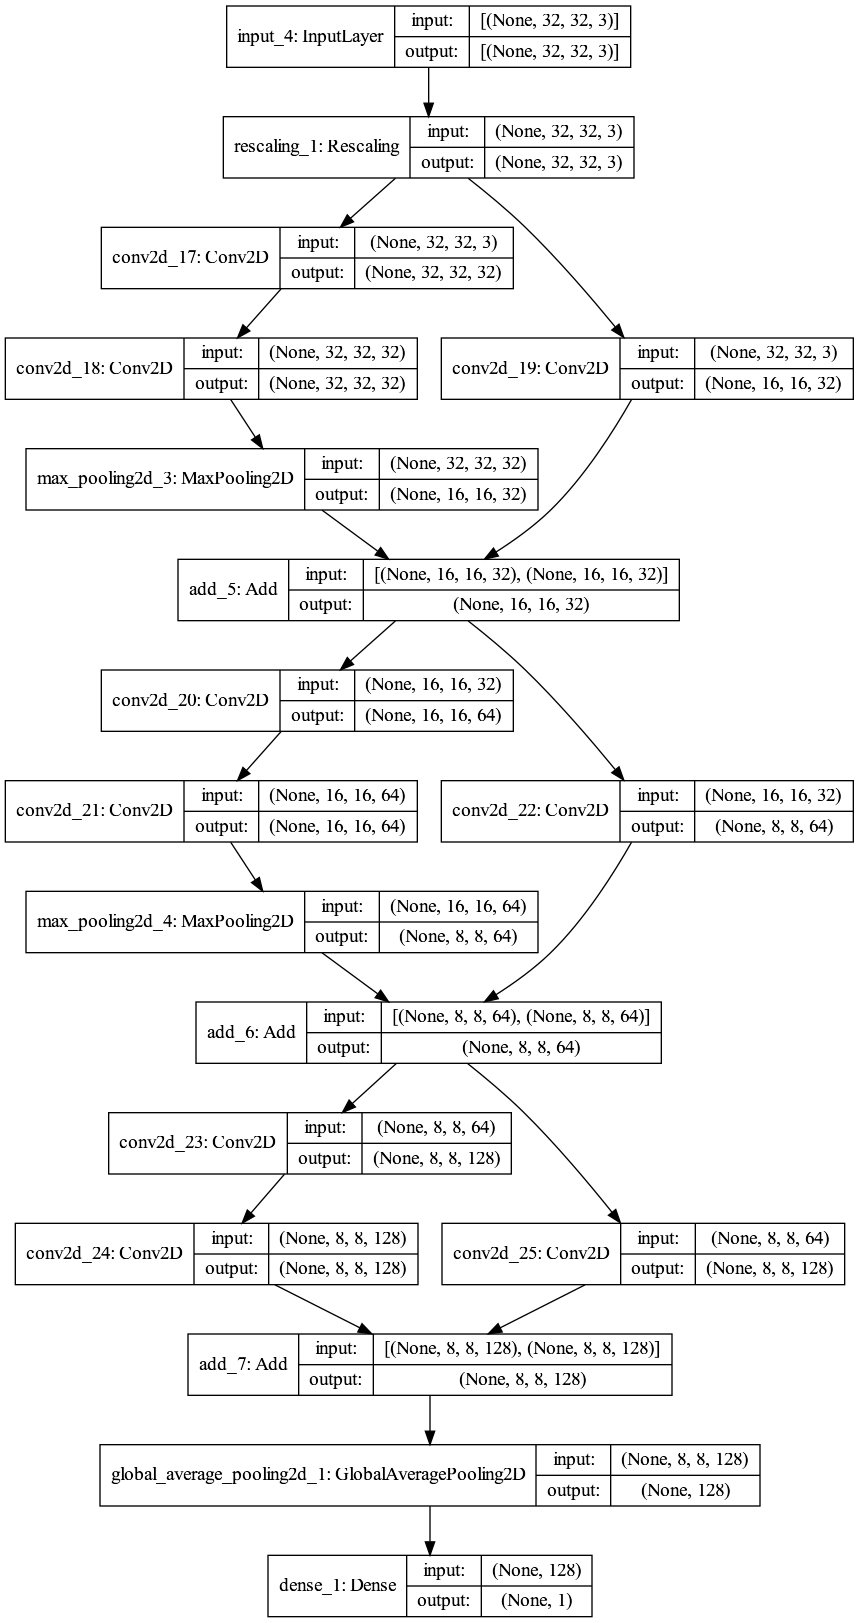

In [12]:
keras.utils.plot_model(model, "9.2.png", show_shapes=True)

可视化清楚多了.

## 批量规范化/归一化

数据归一化是一类应用广泛的方法,旨在使得机器学习模型看到的数据更加相似.


In [13]:
# normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)

我们已经接触过一类应用广泛的数据归一化了.(波士顿房价预测)

特征标准化 = (特征值 - 均值) / 标准差

这实际上是假定数据是按照正态分布,并确保处理后数据分布是在 0 两侧的标准正态分布.


在前文的大部分例子中,数据输入模型前就已经进行过归一化了.但是数据输入模型后,再从一个 layer 输出的数据,还会是均值0方差1的分布吗?

没有理由证伪或者证真,处于安全考虑,不能保证.

另一个问题,对中间层数据进行归一化会有什么帮助?回答这个问题前,向了解一下批量规范化.


批量规范化(Batch Normalization or BN): 每次进行梯度下降的训练时,通过 mini-batch 对网络响应规范化,使得输出结果均值 0方差1.

BN 可以自适应的规范化数据,即使训练期间数据的平均数和方差在不断变化.

- 训练过程中,BN 使用的是当前批次数据的均值和方差进行归一化.
- 在推理过程中,BN 使用训练中看到所有数据的批次均值的均值 和 方差的均值 进行归一化.


回到问题: 对中间层数据进行归一化会有什么帮助?

批量规范化已经在实践中广泛应用,已经被实践证明了的好处

- 允许更深层的网络
- 减轻了对参数初始化的依赖
- 训练更快,学习率也能渠道更高.
- 模型泛化能力更强了一点(存疑)

虽然 BN 有诸多好处,但是迄今为止没有人完整证明为什么 BN 有效.当然有各种假说,但是目前没有完全服众的理论.


我们知道 BN 有效,但是我们不知道为什么 BN 有效.这可能是深度学习中不可避免的一个尴尬.

深度学习现在还不是一门精确的科学,有很多是从工程和实践来的不那么能精确描述的内容.

---

无关吐槽/请忽略

或许某个图灵/香农似的人物可以将深度学习推动到彻底的理论化.或许未来甚至连怎么调参这些经验化内容都是从另外一个模型中学到的,而人完全无法理解为什么这样会生效,连假说都没有.正如围棋领域,当机器的水平远远超过人类,人类的各种定式和围棋理论回头看才漏洞百出.当人连机器给出的结果甚至无法解释时,此时或许只有第一个真正意义上的人工智能才能看得懂这些模型吧.

---


In [14]:
# x = ...
# x = layers.Conv2D(32, 3, use_bias=False)(x)
# x = layers.BatchNormalization()(x)

批量规范层可用在任何层后面直接使用


全连接层和 cnn 层都会使用 bias vector(偏置向量)来使得该层输出与输入成非纯线性,而归一化步骤是将层的输出集中在 0,因此使用批量规范化以后可以设置 `use_bias=False` 使得该层略微精简.


In [15]:
x = keras.Input(shape=(32, 32, 3))

In [16]:
x = layers.Conv2D(32, 3, activation="relu")(x)  #正常写法 带激活
x = layers.BatchNormalization()(x)  #批量规范化

但直观上我们会直接写出上面的堆叠,但这并不是作者建议的写法.


In [17]:
x = layers.Conv2D(32, 3, use_bias=False)(x)  #不带激活
x = layers.BatchNormalization()(x)  #规范化
x = layers.Activation("relu")(x)  #激活

作者建议将激活函数放到批量规范化层之后,这是一条有争议的建议.

作者的理由是 relu 激活函数是将 0 作为保留/放弃激活的支点.而归一化后,数据均值为 0,能最大程度上利用激活函数.

这样做的影响可能并不大,如果还是按照 卷积-激活-批量规范化 模型依然可用训练且结果不一定会差.


关于批量规范化最后一点是: 在微调模型时,尽量冻结批量规范层,再进行微调.

微调本来的更新就非常小了,批量规范层可能会干扰这样的更新.


## 深度可分离卷积

正常的卷积区别是对一次性计算全部深度轴,深度可分离卷积是每个深度通道单独计算.逐通道卷积.

keras 中是 `SeparableConv2D`.

![depthwise_separable_conv](depthwise_separable_conv.png)

如同上图所示,深度可分离卷积先对每个通道单独卷积,最终将结果输入混合通道.


深度可分离卷积是依赖于一个假设--图像的模式与空间位置高度相关但不同通道是相互独立的.

深度可分离卷积是将空间位置和通道特征学习分离.与常规卷积相比,深度可分离卷积需要的参数和计算要少甚多,同时具有相当的表示能力.结果就是深度可分离卷积的模型更小,收敛更快,更不容易过拟合.当数据有限时,效果非常明显.

当涉及更大规模模型时,深度可分离卷积是 Xception 架构的基础.更多深入内容详情见 [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)


### 硬件/软件/算法

考虑一个输入 3x3x64 输出 64 的常规 cnn.其使用 `3*3*64*64=36864` 个参数,一个等效的深度可分离卷积则是 `3*3*64+64*64=4672` 个参数.如果相同的卷积网络应用在图像时,需要计算的浮点运算与参数数量成正比.所以等效的深度可分离卷积会比常规卷积快的多吗?

答案是,对也不对.如果上述卷积过程是你自行编写的 cuda 或 c 实现,确实会有等比例的提升.

但是我们日常是调库,跑在 GPU 上面,这里卷积的运行就不是简单自行实现的情况了.

实际上跑在 GPU 的是一个 cuDNN 内核,是一段经过特别优化的代码,老黄的硬件上每天要跑非常多的 exaFLOPS 运算,因此进行了特别的优化.

但是其他类型的运算并没有获得同等的优化,导致其他类型运算哪怕是其使用的参数和浮点操作都大为减少,它们的速度可能只有常规卷积的一半.

整个软件/硬件的生态环境在为人们大量使用的算法优化(特别是反向传播的卷积网络),以至于使用其他方法的代价高昂无比.即使尝试理论上更新的算法,将计算量缩减几倍那种,其实际的运行效果可能会比现在的卷积+反向传播慢几个数量级.在学术上发论文还好,但是在市场上,销售会吃了你.

---

这个过程有点像生物进化的过程,拿人体举例子,如果有工程师参与人体设计,他一定会在简历上抹去这段经历.因为到处都是不合理/冗余/低效的设计.这些是进化的代价和痕迹,不合理但是能更好完成现有工作.

---

深度学习是硬件/软件/算法之间共同进化的产物: 老黄的 GPU/CUDA 使得早期反向传播网络的成功,早期网络算法的大规模使用又使得老黄进行专门的软硬件优化,这又反过来使得算法背后的社区不断整合(另一个结果是大规模的深度学习 AMD 份额还是很低).如果有不同的道路可能要对整个生态进行多年的改造.
